## zeroshot integration

#### we provide the lung dataset from SCIB (doi.org/10.1038/s41592-021-01336-8)
you can download the sampled dataset from: https://figshare.com/ndownloader/files/24539942
/nfs/public/cell_gpt_data/Intergation_Data/Lung/Lung_atlas_public.h5ad

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3" ## set your available devices, each use ~2G GPU-MEMORY
import scanpy as sc

In [2]:
import scMulan

In [3]:
from scMulan import GeneSymbolUniform

## 1. load h5ad
It's recommended that you use h5ad here with raw count (and after your QC)

In [4]:
adata_path = '/nfs/public/cell_gpt_data/Intergation_Data/Lung/Lung_atlas_public.h5ad' # the data path

In [5]:
adata = sc.read_h5ad(adata_path)

In [ ]:
adata = sc.read(
    "data/lung_atlas.h5ad",
    backup_url="https://figshare.com/ndownloader/files/24539942",
)

  0%|          | 0.00/972M [00:00<?, ?B/s]

In [ ]:
adata

In [6]:
adata

AnnData object with n_obs × n_vars = 32472 × 15148
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'
    layers: 'counts'

## 2. transform original h5ad with uniformed genes (42117 genes)

In [7]:
adata_GS_uniformed = GeneSymbolUniform(input_adata=adata,
                                 output_dir="/nfs/public/chenyx/scMulan_test/uniformed_adata/",
                                 output_prefix='lung')

The shape of query data is: (32472, 15148)
The length of reference gene_list is: 42117
Performing gene symbol uniform, this step may take several minutes


Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15148/15148 [00:12<00:00, 1250.63it/s]

Building output data, this step may take several minutes



Processing: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13972/13972 [00:09<00:00, 1505.76it/s]


Shape of output data is (32472, 42117). It should have 42117 genes with cell number unchanged.
h5ad file saved in:/nfs/public/chenyx/scMulan_test/uniformed_adata/lung_uniformed.h5ad
report file saved in: /nfs/public/chenyx/scMulan_test/uniformed_adata/lung_report.csv


## 3. process uniformed data (simply norm and log1p)

In [21]:
## you can read the saved uniformed adata

#adata_GS_uniformed=sc.read_h5ad('/nfs/public/chenyx/scMulan_test/uniformed_adata/liver_uniformed.h5ad')

In [8]:
adata_GS_uniformed

AnnData object with n_obs × n_vars = 32472 × 42117
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor'

In [9]:
# norm and log1p count matrix
if adata_GS_uniformed.X.max() > 10:
    sc.pp.normalize_total(adata_GS_uniformed, target_sum=1e4) 
    sc.pp.log1p(adata_GS_uniformed)

## 4. use model

In [7]:
from importlib import reload
reload(scMulan)
reload(scMulan.scMulan)

<module 'scMulan.scMulan' from '/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/scMulan/scMulan.py'>

In [10]:
ckp_path = '/nfs/public/cell_gpt_data/dataHub/datasets/datasets/ECA_GO/model_hub/ckpt_scMulan.pt'

In [11]:
scml = scMulan.model_inference(ckp_path, adata_GS_uniformed)
base_process = scml.cuda_count()

number of parameters: 368.80M


/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/anndata/_core/anndata.py:1105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


✅ adata passed check
👸 scMulan is ready
scMulan is currently available to 4 GPUs.


In [12]:
scml.get_cell_types_and_embds_for_adata(parallel=True, n_process = base_process)

adata is not sparse, use dense matrix and dataframe
⚡ Speed up by multiprocessing with 4 processes and 4 GPUs...


⏳ Generating cell type labels and embds for each cell on device 0: 100%|██████████| 8118/8118 [03:47<00:00, 35.73it/s]
⏳ Generating cell type labels and embds for each cell on device 1: 100%|██████████| 8118/8118 [06:43<00:00, 20.12it/s]
⏳ Generating cell type labels and embds for each cell on device 3: 100%|██████████| 8118/8118 [07:38<00:00, 17.70it/s]
⏳ Generating cell type labels and embds for each cell on device 2: 100%|██████████| 8118/8118 [07:43<00:00, 17.52it/s]


The predicted cell types are stored in scml.adata.obs['cell_type_from_scMulan'], besides the cell embeddings (for multibatch integration) in scml.adata.obsm['X_scMulan'].

## 5. visualization

In [19]:
adata_embds = sc.AnnData(scml.adata.obsm['X_scMulan'].copy())
adata_embds.obs = scml.adata.obs

In [22]:
adata_embds

AnnData object with n_obs × n_vars = 32472 × 1120
    obs: 'dataset', 'location', 'nGene', 'nUMI', 'patientGroup', 'percent.mito', 'protocol', 'sanger_type', 'size_factors', 'sampling_method', 'batch', 'cell_type', 'donor', 'cell_type_from_scMulan'
    uns: 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

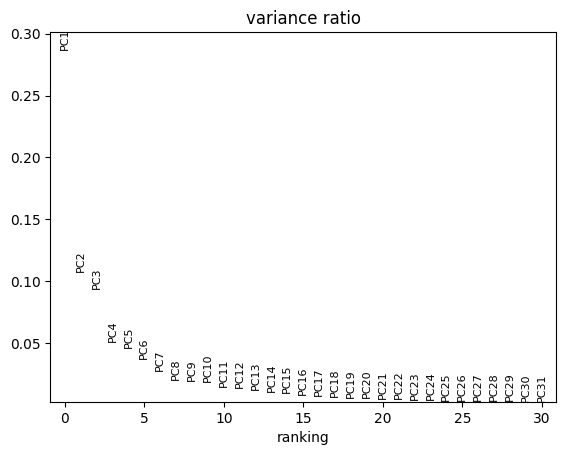

In [27]:
sc.pp.pca(adata_embds)
sc.pl.pca_variance_ratio(adata_embds)
sc.pp.neighbors(adata_embds,n_pcs=8)
sc.tl.umap(adata_embds)

In [28]:
# you can run smoothing function to filter the false positives
scMulan.cell_type_smoothing(adata_embds, threshold=0.1)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32472/32472 [00:14<00:00, 2199.64it/s]
/home/bianhaiyang/projects/cellgpt_v1/tools/scMulan_package/scMulan/utils/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.cell_type_from_mulan_smoothing[adata.obs.smoothing_score<threshold] = "Unclassified"


/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotti

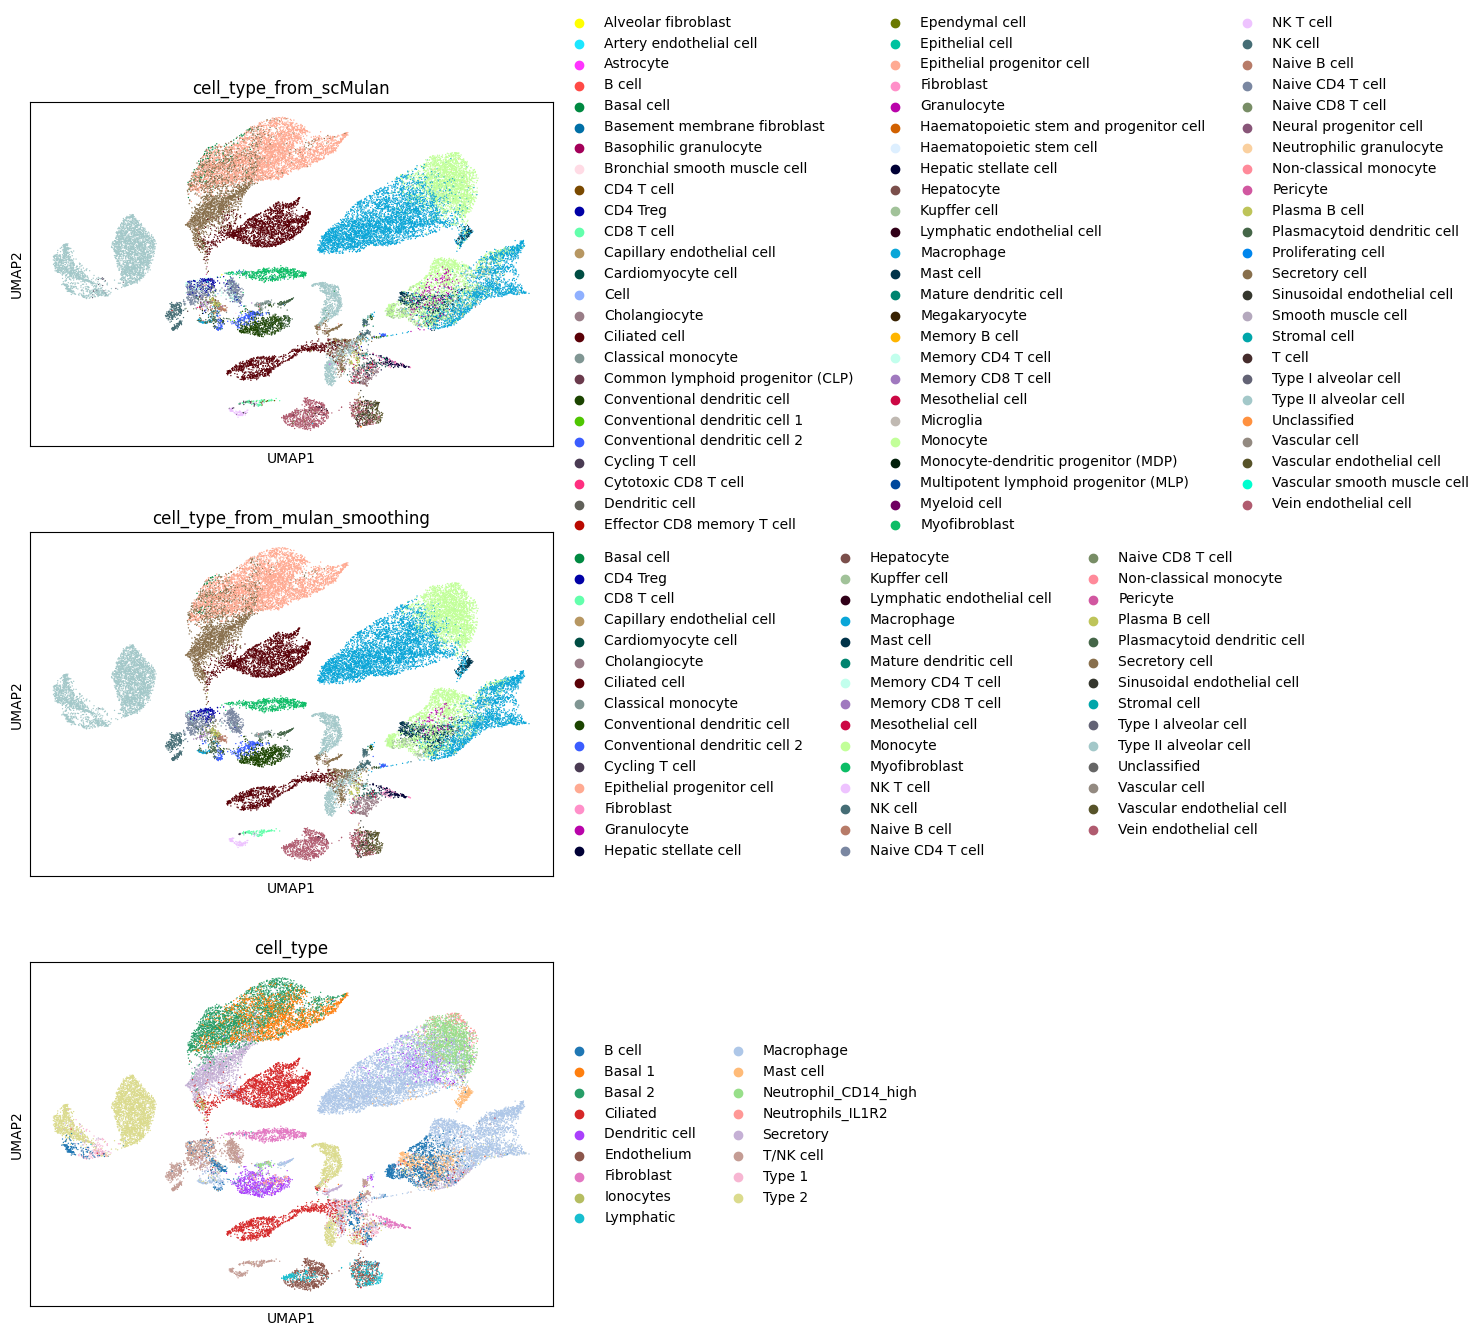

In [29]:
sc.pl.umap(adata_embds,color=["cell_type_from_scMulan","cell_type_from_mulan_smoothing",'cell_type'],ncols=1)

/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1208: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1217: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/bianhaiyang/anaconda3/envs/cellgpt/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


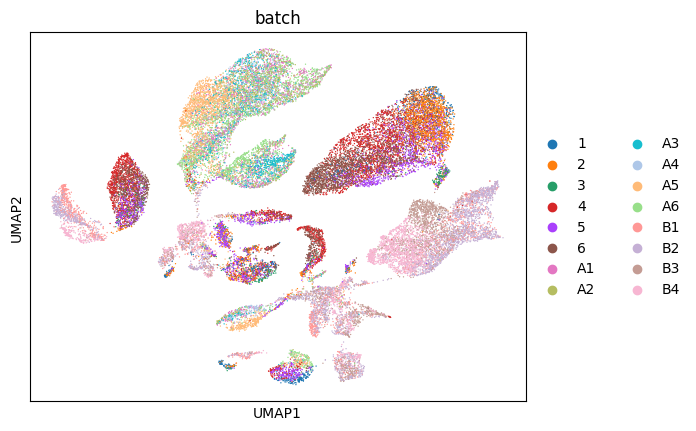

In [30]:
sc.pl.umap(adata_embds, color = ['batch'])